# Семинар 2 - Цветовые пространства, гистограммы изображений, интегральные изображения

***

**Данный семинар содержит оцениваемые упражнения и вопросы.**

Система оценивания: доля правильно решенных упражений. Максимальный балл, соответственно, 1.

В упражнениях оценивается два аспекта:
1. Код проходит assert'ы (если они есть)
2. Код корректен с точки зрения логики

Вопросы также оцениваются. Ответ на них нужно записывать в соответствующие markdown-ячейки.

Источник используемого аэрофотоснимка: https://sovzond.ru/upload/medialibrary/267/%D0%98%D1%81%D1%85%D0%BE%D0%B4%D0%BD%D1%8B%D0%B9-%D0%B0%D1%8D%D1%80%D0%BE%D1%84%D0%BE%D1%82%D0%BE%D1%81%D0%BD%D0%B8%D0%BC%D0%BE%D0%BA.jpg

In [102]:
from pathlib import Path

import cv2
import numpy as np

import matplotlib.pyplot as plt

In [103]:
AERIAL_IMG_PATH = "data/aerial_image.jpg"
SUNFLOWER_IMG_PATH = "data/sunflower.jpg"

if not Path(AERIAL_IMG_PATH).exists() or not Path(SUNFLOWER_IMG_PATH).exists():
    !git clone https://github.com/alexmelekhin/cv_course_2023.git
    !mv cv_course_2023/seminars/seminar_02/data .

## 1. Цветовые пространства

Наиболее распространенным представлением цвета пикселя является пространство RGB. В таком представлении цвет представлен тремя числами: интенсивностями красного, зеленого и синего базисных цветов.

In [104]:
img = cv2.imread(SUNFLOWER_IMG_PATH)

In [105]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

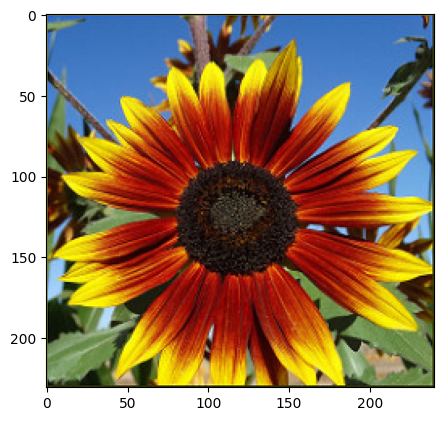

In [106]:
plt.figure(figsize=[5, 5])
plt.imshow(img_rgb)

cvtColor поддерживает конвертацию между множеством других цветовых схем. К примеру, чтобы получить серое изобаржение из цветного достаточно:

In [107]:
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

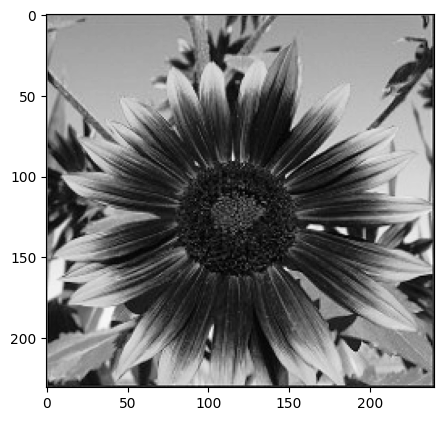

In [108]:
plt.figure(figsize=[5, 5])
plt.imshow(img_gray, cmap='Greys_r')

Если не предполагается использовать информацию о цвете пикселей, то можно сразу загрузить изображение в оттенках серого:

In [109]:
img_gray = cv2.imread(SUNFLOWER_IMG_PATH, cv2.IMREAD_GRAYSCALE)

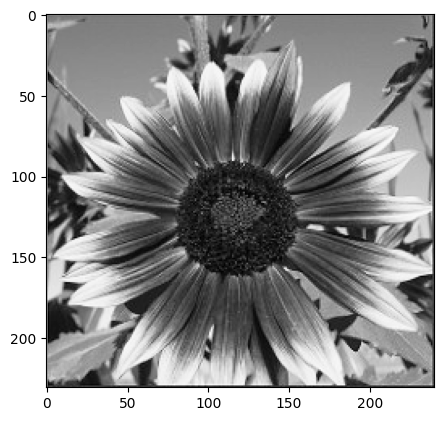

In [110]:
plt.figure(figsize=[5, 5])
plt.imshow(img_gray, cmap='Greys_r')

серое изображение - двумерный массив:

In [111]:
print('type(img_gray) = ', type(img_gray))
print('img_gray.shape = ', img_gray.shape)
print('img_gray.dtype = ', img_gray.dtype)

type(img_gray) =  <class 'numpy.ndarray'>
img_gray.shape =  (231, 240)
img_gray.dtype =  uint8


## Упражнение 1: RGB $\to$ gray

**Это и все последующие упражения - оцениваемые, для самостоятельной работы.**

Реализуйте функцию преобразования цветного изображения в формате RGB в серое

In [112]:
import decimal

def convert_rgb_to_grayscale(img_rgb):
    return np.round(0.29901 * img_rgb[:,:,0] + 0.58701 * img_rgb[:,:,1] + 0.1140 * img_rgb[:,:,2])

In [113]:
assert((cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY) == convert_rgb_to_grayscale(img_rgb)).all())

## Вопрос 1

**Этот и все последующие вопросы - оцениваемые, для самостоятельной работы.**

Почему бы не использовать при преобразовании в серое просто среднее арифметическое?

**Ответ:** человеческий глаз воспринимает красный, целеный и синий не одинаково.

Кроме RGB/BGR и grayscale существуют и другие цветовые представления. Преобразования между ними можно осуществлять с помощью библиотеки OpenCV следующим способом:

## RGB $\to$ HSV

In [114]:
img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

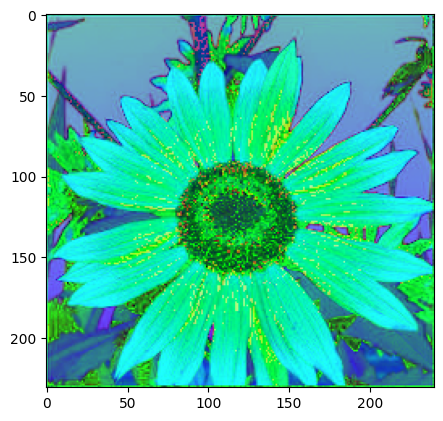

In [115]:
plt.figure(figsize=[5, 5])
plt.imshow(img_hsv)

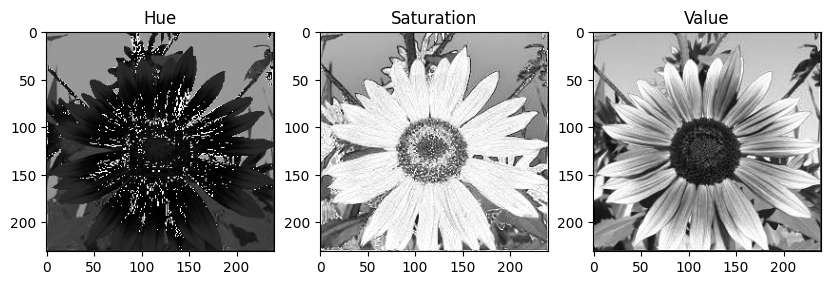

In [116]:
# Split the image into color channels
h, s, v = cv2.split(img_hsv)

plt.figure(figsize=[10, 30])
plt.subplot(131)
plt.imshow(h, cmap="gray")
plt.title('Hue')

plt.subplot(132)
plt.imshow(s, cmap="gray")
plt.title('Saturation')

plt.subplot(133)
plt.imshow(v, cmap="gray")
plt.title('Value')

# Display the plot
plt.show()


## Упражнение 2

Попробуйте другие цветовые пространства, конвертация в которые реализована в OpenCV.

In [117]:
img_luv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LUV)

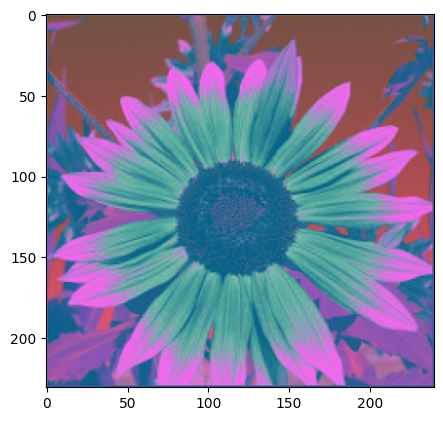

In [118]:
plt.figure(figsize=[5, 5])
plt.imshow(img_luv)

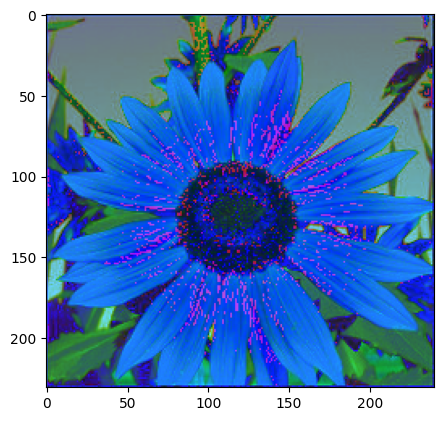

In [119]:
img_hls = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HLS)
plt.figure(figsize=[5, 5])
plt.imshow(img_hls)

## Вопрос 2

В каких задачах переход из RGB в другое цветовое пространство может быть полезным?

**Ответ:** чтобы посмотреть, как изображение будет выглядеть при печати, нужно перевести его в CMYK. Для выделения ярких областей на изображении полезно перевести его в HUV пространство.

## Гистограмма изображения

Напомним, что гистограммой изображения называется функция, показыващая количество пикселей изображения с заданным в качестве аргумента значением интенсивности:

$$
    h(v) = \sum_{x = 0}^{W - 1} \sum_{y = 0}^{H - 1} [f(x, y) = v] 
$$

Если дополнительно потребовать, чтобы $\sum_{v = 0}^{255} h(v) = 1$, то $h$ будет представлять функцию плотности распределения интенсивности на изображении.

Определим вспомогательную функцию, позволяющую визализировать гистограмму:

In [120]:
def visualize_hist(hist, title=None):
    plt.figure(figsize=[20, 5])
    if title:
        plt.title(title)
    plt.bar(np.arange(len(hist)), hist / hist.sum())

Рассчитать гистограмму можно с помощью встроенной функции OpenCV:

In [121]:
hist_cv = cv2.calcHist([img_gray],      # список изображений
                       [0],             # список каналов
                       None,            # маска (без маски)
                       [256],           # размер гистограммы
                       [0, 256])[:, 0]  # диапазон значений

Результат представляет собой обычный массив длины 256:

In [122]:
print('hist_cv.shape = ', hist_cv.shape)

hist_cv.shape =  (256,)


и выглядит следующим образом:

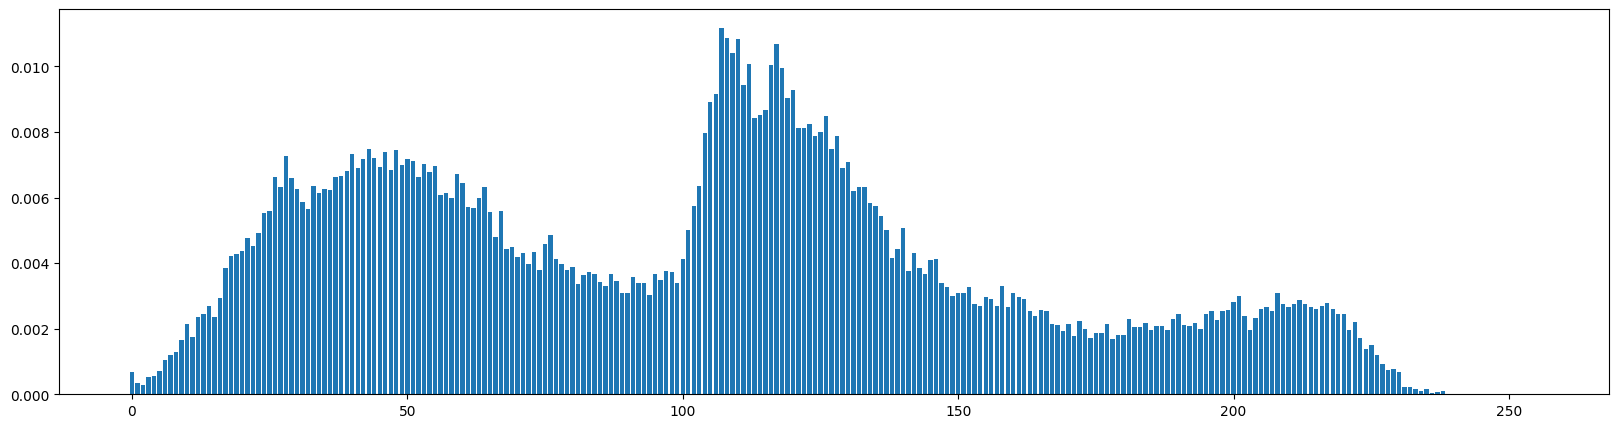

In [123]:
visualize_hist(hist_cv)

## Упражнение 3: Построение гистограммы

Реализуйте функцию для расчета гистограммы изображения. Используйте ее для визуализации трех каналов RGB изображения.

In [124]:
def compute_hist(img):
    if np.max(np.max(img))>256:
        hist = np.full((np.max(np.max(img))+1), 0)
    else:
        hist = np.full((256), 0)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            hist[img[i,j]]+=1
    return hist


In [125]:
hist_gray = compute_hist(img_gray)

hist_r = compute_hist(img_rgb[:, :, 0])
hist_g = compute_hist(img_rgb[:, :, 1])
hist_b = compute_hist(img_rgb[:, :, 2])

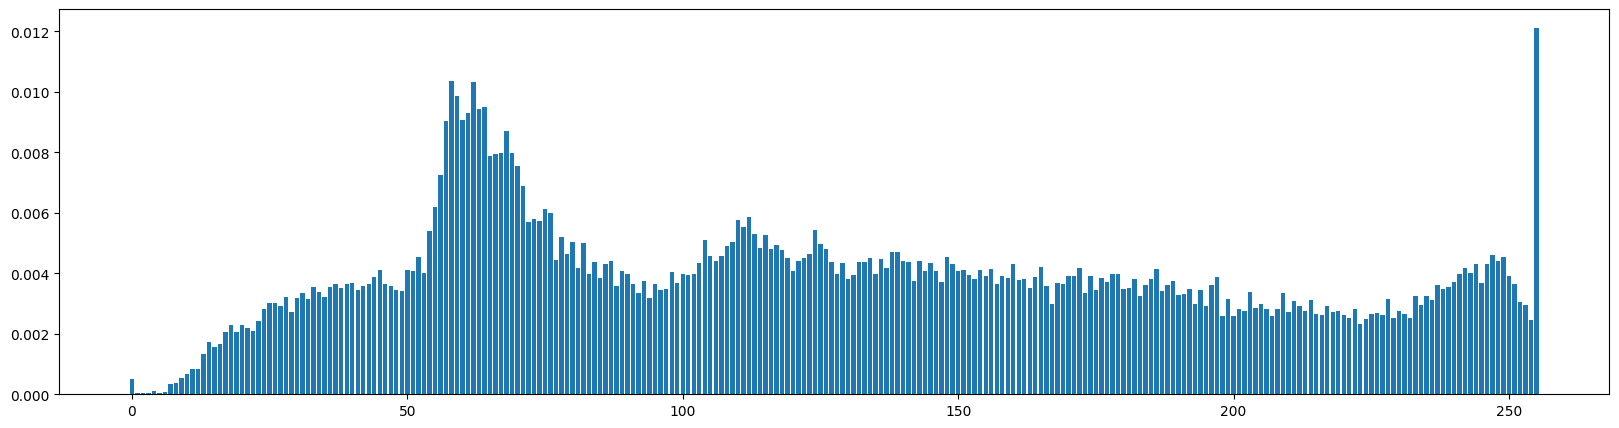

In [126]:
visualize_hist(hist_r)

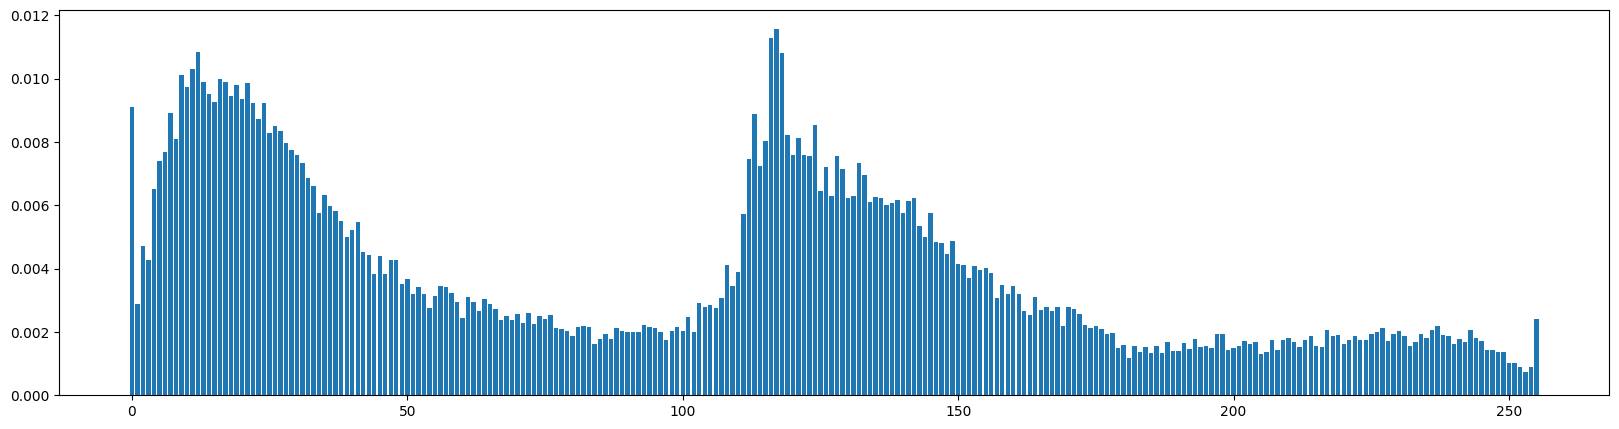

In [127]:
visualize_hist(hist_g)

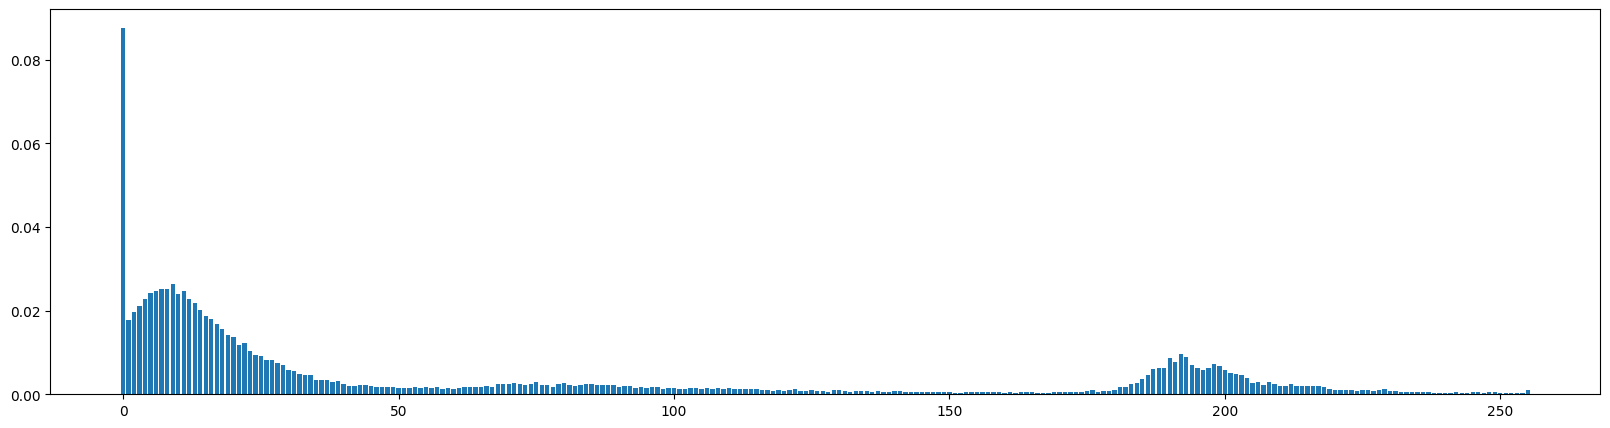

In [128]:
visualize_hist(hist_b)

In [129]:
assert((hist_gray == hist_cv).all())

## Вопрос 3

 Что можно сказать об изображении по его гистограмме?

**Ответ:** по гистограмме в gray scale можно сказать, какие цвета преобладают: светлые или темные.

## Вопрос 4

Допустим, вы смотрите некоторый фильм и для текущего кадра выводите его гистограмму. Как будет меняться эта гистограмма с течением времени?

**Ответ:** пока длится одна сцена, гистограмма будет меняться плавно. При смене сцены произойдет резкое изменение гистограммы.

## Упражнение 4: JPEG и гистограмма

Исследуйте, как влияет степень сжатия алгоритма JPEG на вид гистограммы изображения.

Используйте черно-белое изображение `img_gray`. Визуализируйте степени сжатия 90, 60, 30, 5.

In [130]:
cv2.imwrite('img_gray90.jpg', img_gray, [cv2.IMWRITE_JPEG_QUALITY, 90])
cv2.imwrite('img_gray60.jpg', img_gray, [cv2.IMWRITE_JPEG_QUALITY, 60])
cv2.imwrite('img_gray30.jpg', img_gray, [cv2.IMWRITE_JPEG_QUALITY, 30])
cv2.imwrite('img_gray5.jpg', img_gray, [cv2.IMWRITE_JPEG_QUALITY, 5])

True

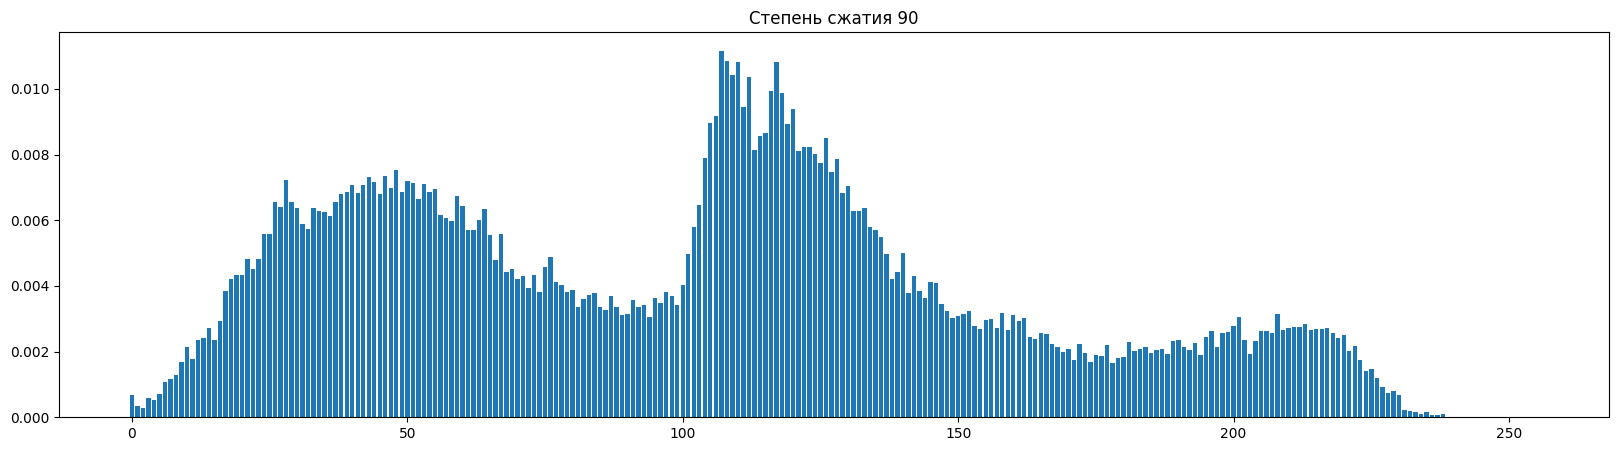

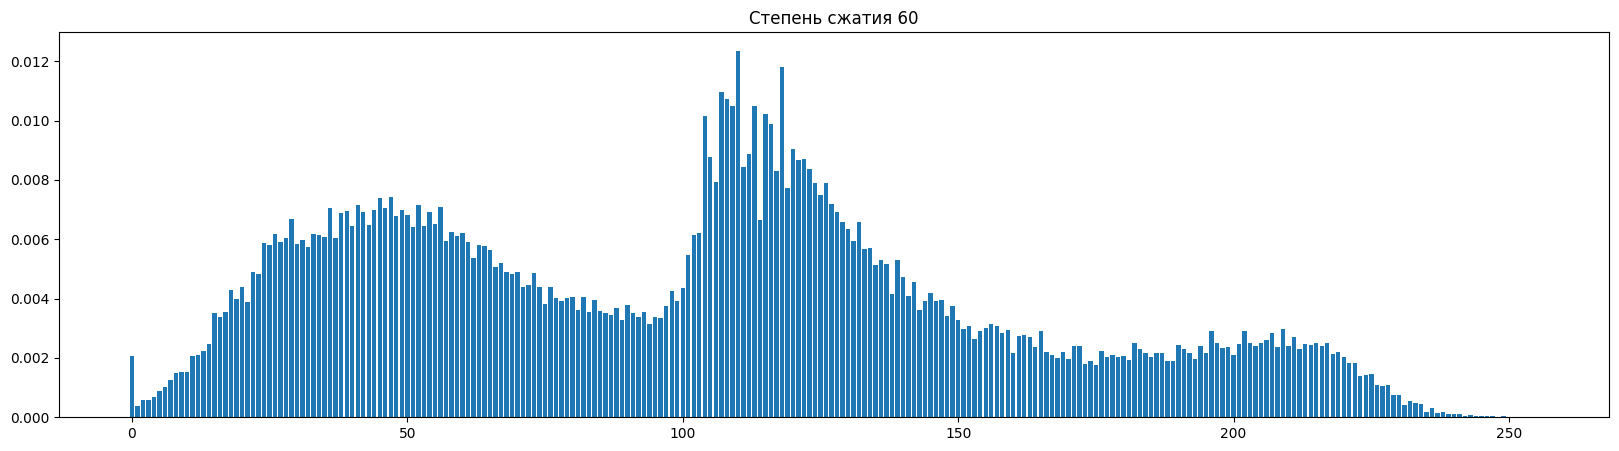

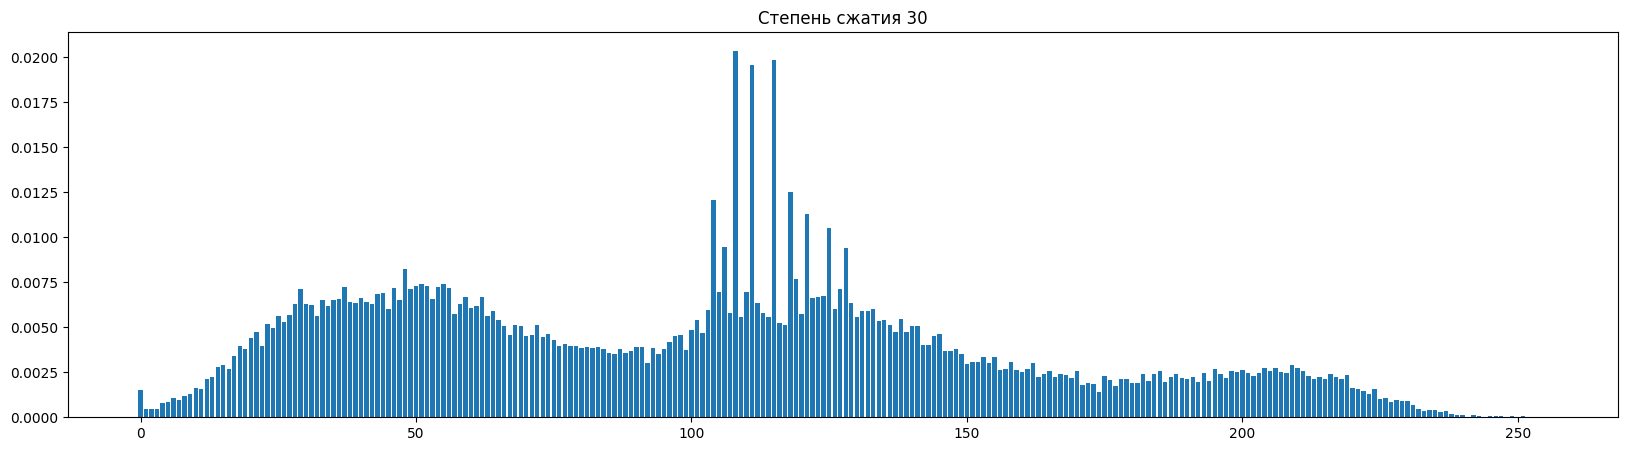

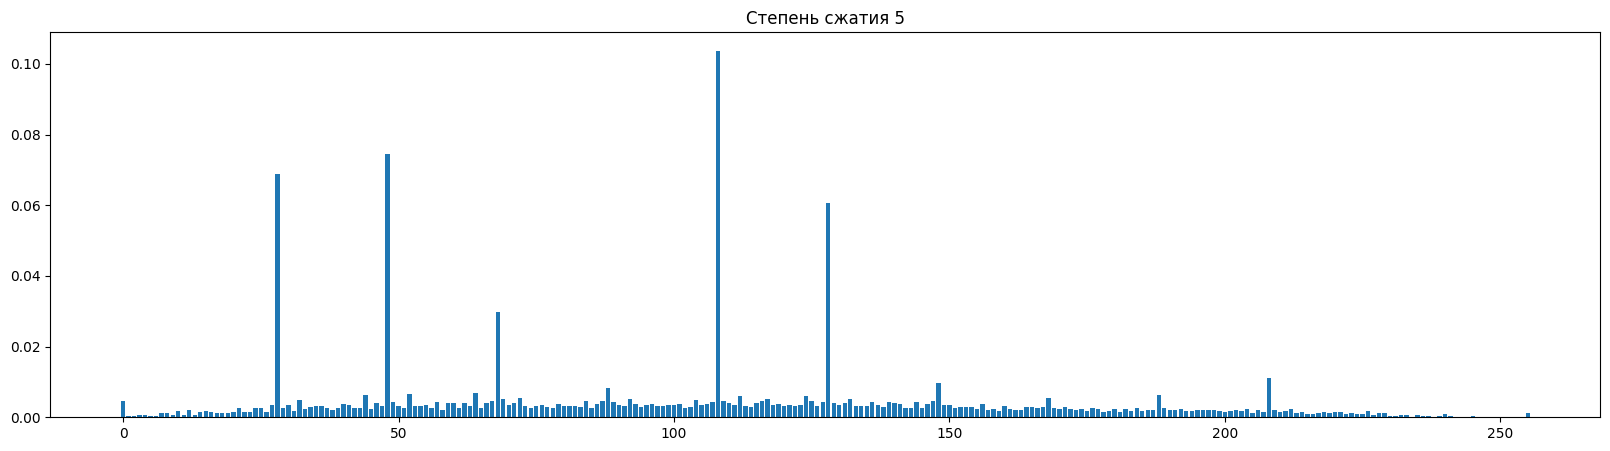

In [131]:
img_gray90 = cv2.imread('img_gray90.jpg')
hist_gray90 = compute_hist(img_gray90)
img_gray60 = cv2.imread('img_gray60.jpg')
hist_gray60 = compute_hist(img_gray60)
img_gray30 = cv2.imread('img_gray30.jpg')
hist_gray30 = compute_hist(img_gray30)
img_gray5 = cv2.imread('img_gray5.jpg')
hist_gray5 = compute_hist(img_gray5)
visualize_hist(hist_gray90, "Степень сжатия 90")
visualize_hist(hist_gray60, "Степень сжатия 60")
visualize_hist(hist_gray30, "Степень сжатия 30")
visualize_hist(hist_gray5, "Степень сжатия 5")

## Упражнение 5: Сегментация

На загруженном аэроортофотоплане выделите зеленые насаждения. Для этого постройте бинарную маску, где 1 будет отвечать наличию насаждений в данном пикселе, 0 - их отсутствию, и визуализируйте её. А также рассчитайте, какую долю изображения занимают зеленые насаждения. С какой ошибкой (погрешностью) получена эта величина?

Подсказка: вам должно помочь HSV пространство и гистограмма. Погрешность может быть оценена на глаз, по вашей неуверенности в определении порога отделения классов 'зеленые насаждения'/'прочее'.

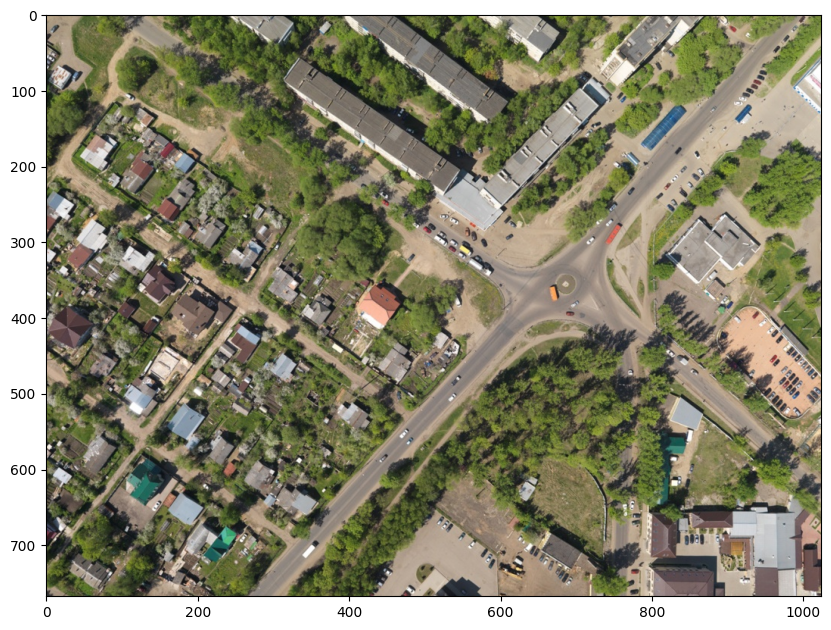

In [132]:
aerial_image = cv2.cvtColor(cv2.imread(AERIAL_IMG_PATH), cv2.COLOR_BGR2RGB)

plt.figure(figsize=[10, 10])
plt.imshow(aerial_image)

In [133]:
hsv_image = cv2.cvtColor(cv2.imread(AERIAL_IMG_PATH), cv2.COLOR_BGR2HSV)

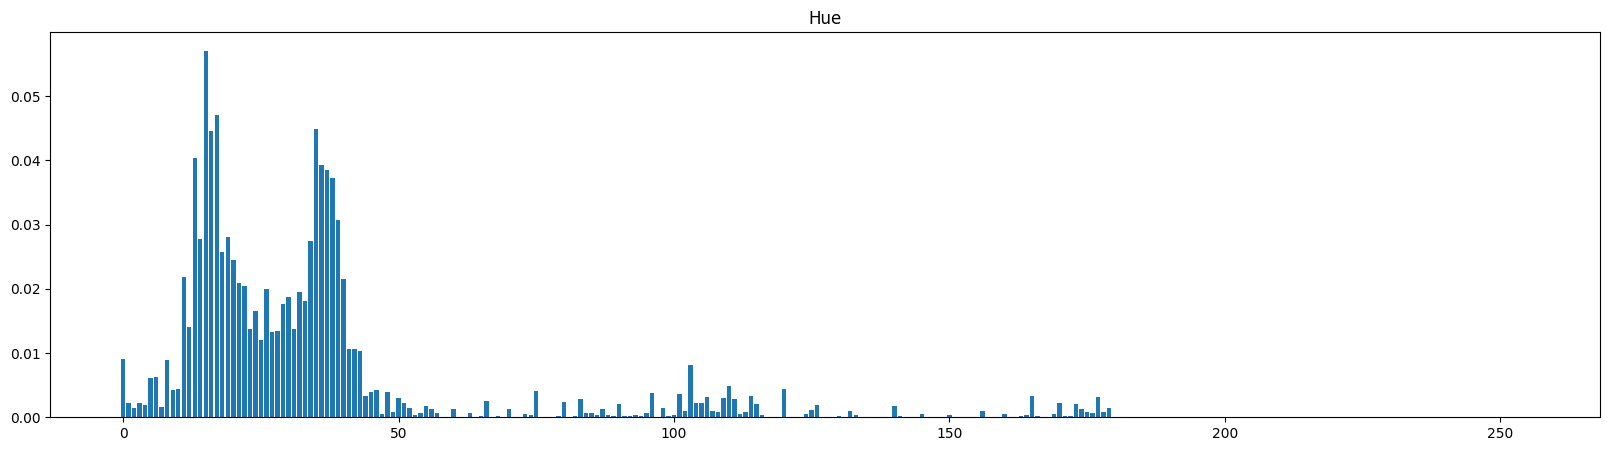

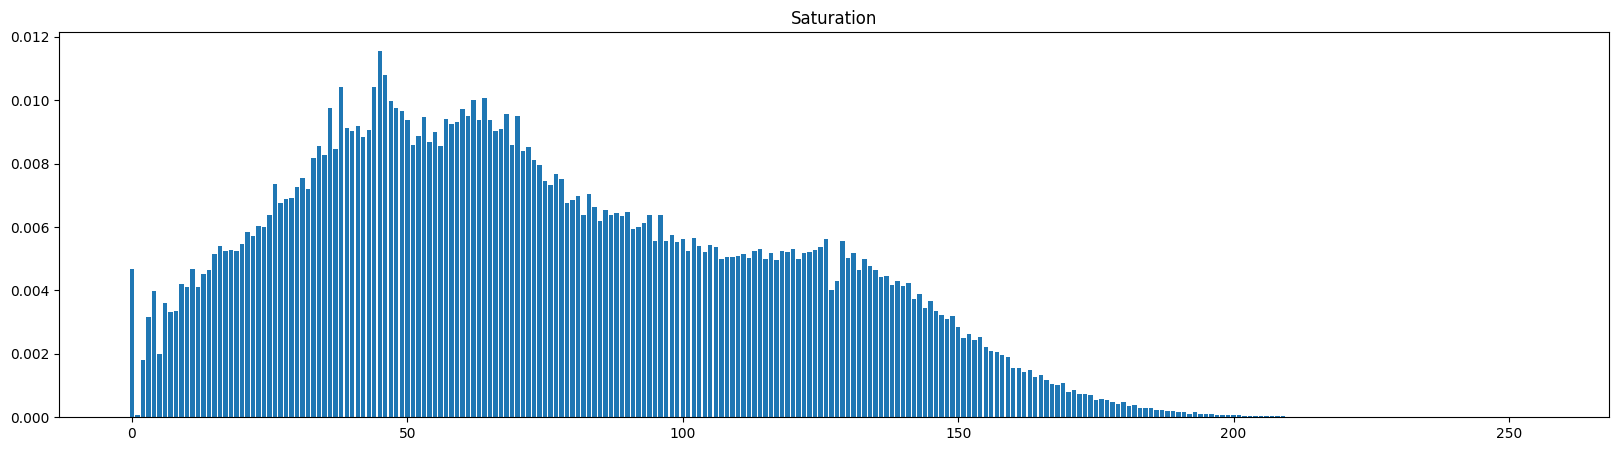

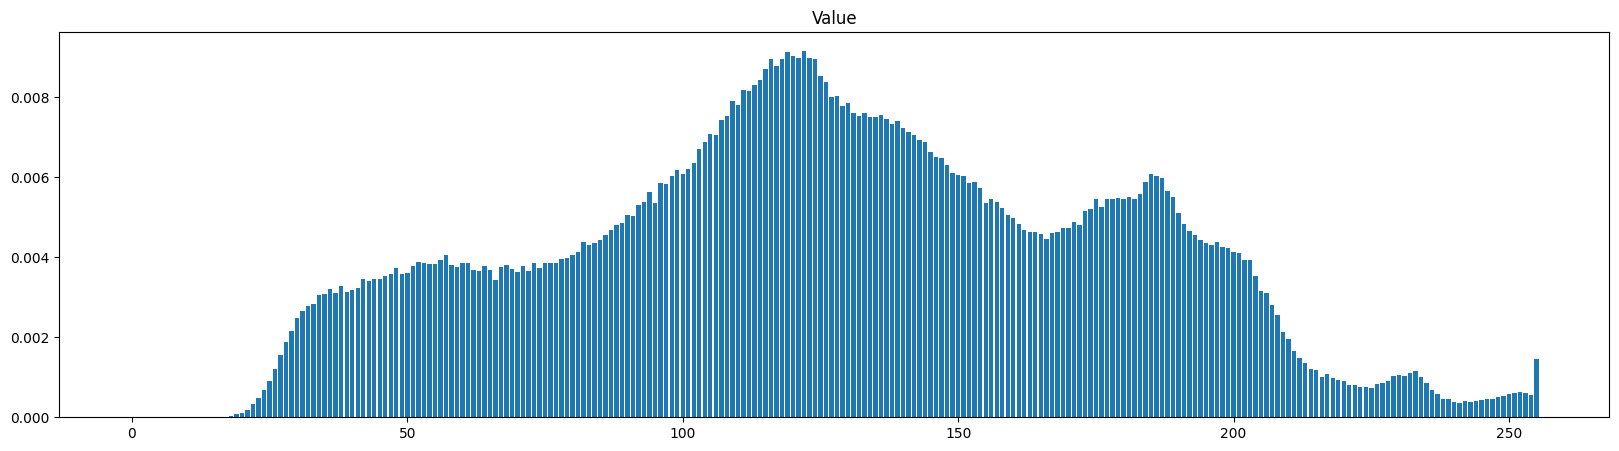

In [134]:
h, s, v = cv2.split(hsv_image)
visualize_hist(compute_hist(h), title='Hue')
visualize_hist(compute_hist(s), title='Saturation')
visualize_hist(compute_hist(v), title='Value')

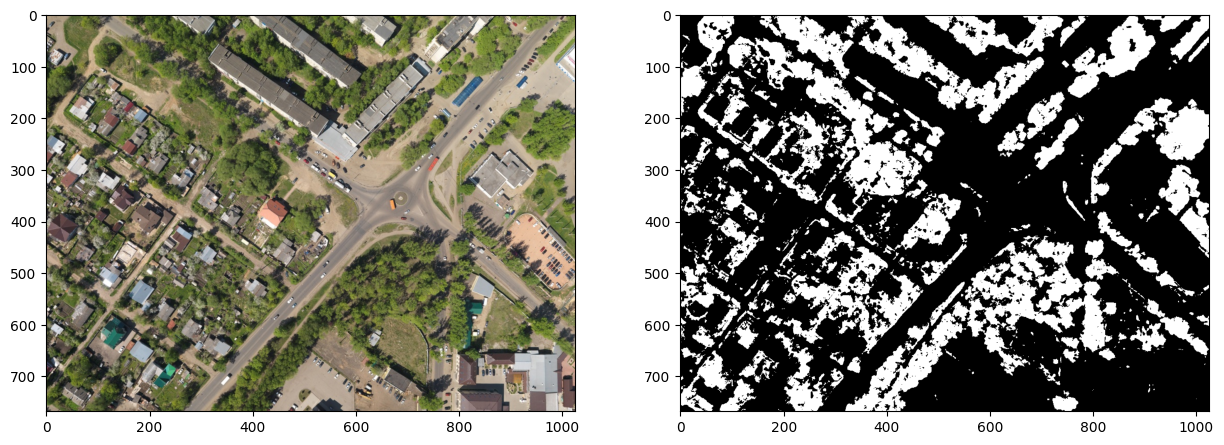

In [135]:
lower_green = np.array([30,50,50])
upper_green = np.array([90,255,255])
# Threshold the HSV image to get only blue colors
mask = cv2.inRange(hsv_image, lower_green, upper_green)
plt.figure(figsize=[15, 10])
plt.subplot(1,2,1)
plt.imshow(aerial_image)
plt.subplot(1,2,2)
plt.imshow(mask, cmap='gray')

In [136]:
mask = (mask == 255).astype(int)

In [137]:
print('Доля зеленых насаждений', np.round(np.sum(mask)/mask.size,2))

Доля зеленых насаждений 0.32


Погрешность может составить примерно 10%, так как низкая трава на снимке выходит за выбранные границы зеленого цвета.

# Упражнение 6: Интегральное изображение
Напомним, что интегральным изображением называется следующая функция:
$$
    I(x, y) = \sum_{i = 0}^{x} \sum_{j = 0}^{y} f(i, j)
$$
С помощью интегрального изображения можно за $O(1)$ вычислять сумму интенсивностей в произвольной прямоугольной области. Требуется реализовать расчет интегрального изображения, а также быстрый расчет сумм интенсивностей в прямоугольнике заданном верхним левым углом, шириной и высотой $x, y, w, h$.

In [141]:
class IntegralImage:

    def __init__(self, img):
        assert(len(img.shape) == 2)  # только для серых изображений

        self.img = img.astype('int64')
        transposed=False
        if img.shape[0]>img.shape[1]:
            self.img = self.img.T
            transposed=True
        
        print(type(self.img[0,0]))

        for i in range(self.img.shape[0]):
            for j in range(i, self.img.shape[0]):
                if i==0 and j==0:
                    self.img[j,i] = self.img[j,i]
                elif i==0:
                    self.img[j,i] = self.img[j,i] + self.img[j-1,i]
                elif j==0:
                    self.img[j,i] = self.img[j,i] + self.img[j,i-1]
                else:
                    self.img[j,i] = self.img[j,i] + self.img[j-1,i] + self.img[j,i-1] - self.img[j-1,i-1]
            for j in range(i+1, self.img.shape[1]):
                if i==0 and j==0:
                    self.img[i,j] = self.img[i,j]
                elif i==0:
                    self.img[i,j] = self.img[i,j] + self.img[i,j-1]
                elif j==0:
                    self.img[i,j] = self.img[i,j] + self.img[i-1,j]
                else:
                    self.img[i,j] = self.img[i,j] + self.img[i-1,j] + self.img[i,j-1] - self.img[i-1,j-1]
        
        if transposed:
            self.img = self.img.T

    def sum(self, x, y, w, h):
        if x>0 and y>0:
            return self.img[y+h-1, x+w-1]-self.img[y-1, x+w-1]-self.img[y+h-1, x-1]+self.img[y-1, x-1]
        elif x>0:
            return self.img[y+h-1, x+w-1]-self.img[y+h-1, x-1]
        elif y>0:
            return self.img[y+h-1, x+w-1]-self.img[y-1, x+w-1]
        else:
            return self.img[y+h-1, x+w-1]

In [142]:
I = IntegralImage(img_gray)

<class 'numpy.int64'>


In [143]:
x, y, w, h = 0, 0, 100, 100
assert(img_gray[y:y + h, x:x + w].sum() == I.sum(x, y, w, h))

x, y, w, h = 100, 100, 100, 100
assert(img_gray[y:y + h, x:x + w].sum() == I.sum(x, y, w, h))

## Вопрос 5

В каких задачах может потребоваться использовать интегральное изображение?

**Ответ:**

## Вопрос 6

Какому методу решения задачи в программировании следует метод расчета интегрального изображения?

**Ответ:** динамическому программированию